In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import arch as arch
from arch import arch_model
import datetime

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration

yen_futures = pd.read_csv(
    Path("yen.csv"), 
    index_col="Date", 
    infer_datetime_format=True, 
    parse_dates=True)

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990

yen_futures = yen_futures.loc["1990-01-01":, :]

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

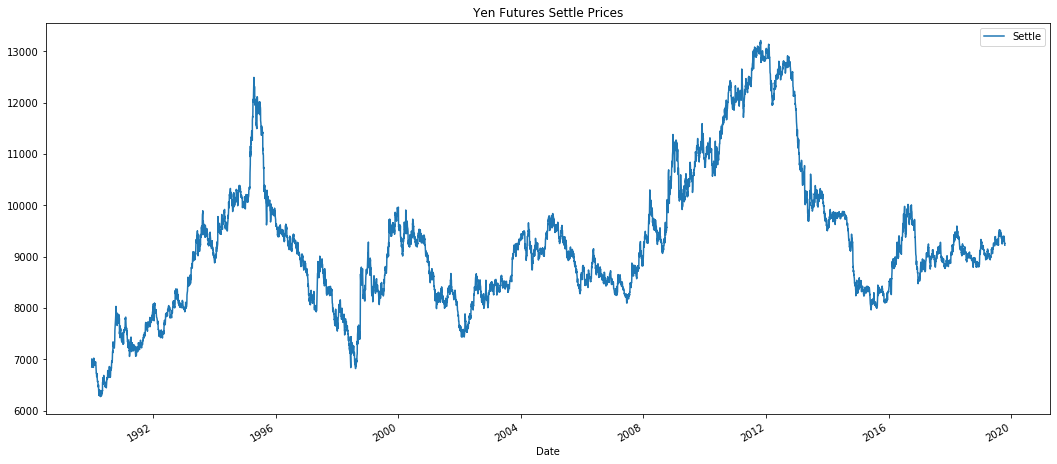

In [5]:
# Plot just the "Settle" column from the dataframe:

yen_futures.Settle.plot(figsize=(18,8), 
                        legend=True, 
                        title="Yen Futures Settle Prices")

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures.Settle, 1600)

In [7]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:

yen_df = pd.DataFrame(yen_futures.Settle)
yen_df["Noise"] = ts_noise
yen_df["Trend"] = ts_trend

yen_df.tail()

,Settle,Noise,Trend
Date,,,
2019-10-09,9338.0,24.939247,9313.060753
2019-10-10,9303.5,-5.868559,9309.368559
2019-10-11,9251.0,-54.454594,9305.454594
2019-10-14,9265.0,-36.423060,9301.423060
2019-10-15,9221.5,-75.844123,9297.344123


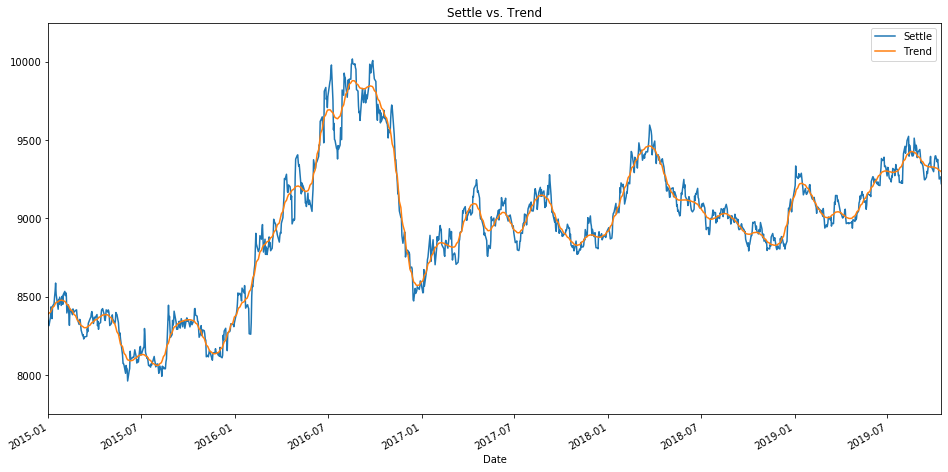

In [8]:
# Plot the Settle Price vs. the Trend

yen_df[["Settle", "Trend"]].plot(figsize=(16,8), 
                                 legend=True, title="Settle vs. Trend", 
                                 xlim=(datetime.date(2015,1,1), datetime.date(2019,10,15)), 
                                 ylim=(7750,10250))


Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

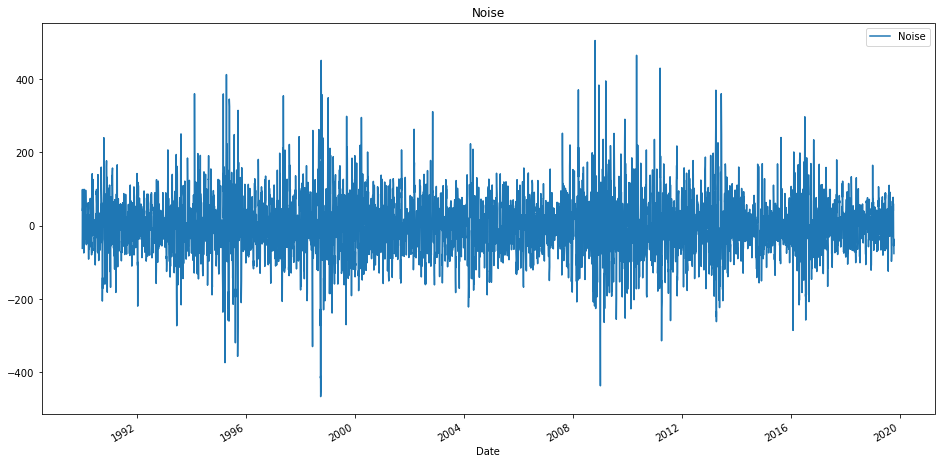

In [9]:
# Plot the Settle Noise

yen_df["Noise"].plot(figsize=(16,8), legend=True, title="Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

returns_arma = (yen_futures[["Settle"]].pct_change() * 100)
returns_arma = returns_arma.replace(-np.inf, np.nan).dropna()

returns_arma.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [11]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))

model_arma = ARMA(returns_arma.values, order=(2,1))

# Fit the model and assign it to a variable called results

results_arma = model_arma.fit()

In [12]:
# Output model summary results:

results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 01 Jul 2020   AIC                          15798.142
Time:                        13:41:14   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2948      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3336           +0.0000j            3.3336            0.5000
AR.2         -157.1516           +0.0000j          157.1516            0.5000
MA.1           -3.3925           +0.0000j            3.3925            0.5000
-----------------------------------------------------------------------------
"""

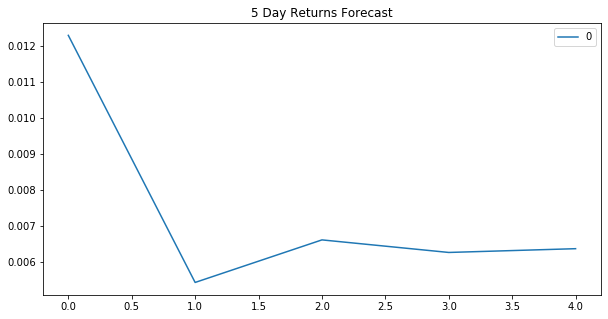

In [13]:
# Plot the 5 Day Returns Forecast

pd.DataFrame(results_arma.forecast(steps=5)[0]).plot(figsize=(10,5), title="5 Day Returns Forecast")

Question: Based on the p-value, is the model a good fit?

Answer:

All the p-values are above a significance of 0.05. According to the graph the yen is forecasted to be positive with a dip from a range of 0.012 to a little below 0.006. 

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [14]:
yen_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7515 entries, 1990-01-02 to 2019-10-15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Settle  7515 non-null   float64
 1   Noise   7515 non-null   float64
 2   Trend   7515 non-null   float64
dtypes: float64(3)
memory usage: 234.8 KB


In [15]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))

model_arima = ARIMA(yen_df["Settle"], order=(5,1,1))

# Fit the model

results_arima = model_arima.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [16]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Wed, 01 Jul 2020   AIC                          83905.238
Time:                        13:41:15   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2819      0.699      0.403      0.687      -1.089       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0127      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.065      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2970      0.699     -0.425      0.671      -1.668       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8915           -1.3789j            2.3407           -0.1003
AR.2            1.8915           +1.3789j            2.3407            0.1003
AR.3           -2.2688           -3.0214j            3.7784           -0.3525
AR.4           -2.2688           +3.0214j            3.7784            0.3525
AR.5          -11.0277           -0.0000j           11.0277           -0.5000
MA.1            3.3674           +0.0000j            3.3674            0.0000
-----------------------------------------------------------------------------
"""

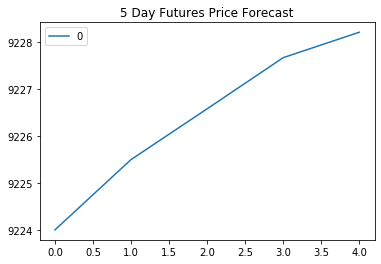

In [17]:
# Plot the 5 Day Price Forecast

pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

What does the model forecast will happen to the Japanese Yen in the near term?

The graph shows the Yen will rise from 9224 to 9228 over the next 5 days.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
# Estimate a GARCH model:

model_garch = arch_model(returns_arma, mean="Zero", vol="Garch", p=1, q=1)

# Fit the model

results_garch = model_garch.fit(disp="off")

In [19]:
# Summarize the model results

results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Wed, Jul 01 2020   Df Residuals:                     7511
Time:                        13:41:16   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [31]:
# Find the last day of the dataset

last_day = returns_arma.index.max().strftime('%Y-%m-%d')

last_day

'2019-10-15'

In [32]:
# Create a 5 day forecast of volatility

forecast_horizon = 5

# Start the forecast using the last_day calculated above

forecasts_garch = results_garch.forecast(start=last_day, horizon=forecast_horizon)

forecasts_garch

In [33]:
# Annualize the forecast

intermediate = np.sqrt(forecasts_garch.variance.dropna() * 252)

intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [34]:
# Transpose the forecast so that it is easier to plot

final = intermediate.dropna().T

final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


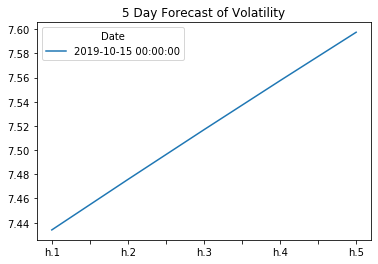

In [35]:
# Plot the final forecast

final.plot(title="5 Day Forecast of Volatility")

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

From the final graph, it looks like volatility is increasing from 7.44 to 7.60 over the next 5 days. Based on the previous graphs, the prices are also increasing. Further analysis would need to be done to surmise if the increase in price is worth the riskiness of the next 5 days. 